In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2023-04-06 11:31:01.299532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('../datasets/goog_train.csv')

In [3]:
train.head(2)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"


In [4]:
# train.iloc[:, 1] returns Series and .values -> 1D array
train.iloc[:, 1].values

array([325.25, 331.27, 329.83, ..., 793.7 , 783.33, 782.75])

In [5]:
# train.iloc[:, 1:2] returns df and .values -> 2D array
# same as
# train.iloc[:, [1]].values

train.iloc[:, 1:2].values

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

In [6]:
train = train.iloc[:, [1]].values

In [7]:
sc = MinMaxScaler()
train = sc.fit_transform(train)

In [8]:
train[:2]

array([[0.08581368],
       [0.09701243]])

In [9]:
train.max(), train.min()

(1.0, 0.0)

Create timestamps.

In [10]:
train[:2]

array([[0.08581368],
       [0.09701243]])

In [11]:
len(train)

1258

In [12]:
X_train = []
y_train = []
for i in range(60, len(train)):
    X_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
y_train[:5]

array([0.08627874, 0.08471612, 0.07454052, 0.07883771, 0.07238262])

In [14]:
X_train[:2]

array([[0.08581368, 0.09701243, 0.09433366, 0.09156187, 0.07984225,
        0.0643277 , 0.0585423 , 0.06568569, 0.06109085, 0.06639259,
        0.0614257 , 0.07474514, 0.02797827, 0.02379269, 0.02409033,
        0.0159238 , 0.01078949, 0.00967334, 0.01642607, 0.02100231,
        0.02280676, 0.02273235, 0.02810849, 0.03212665, 0.0433812 ,
        0.04475779, 0.04790163, 0.0440695 , 0.04648783, 0.04745517,
        0.04873875, 0.03936305, 0.04137213, 0.04034898, 0.04784582,
        0.04325099, 0.04356723, 0.04286033, 0.04602277, 0.05398467,
        0.05738894, 0.05714711, 0.05569611, 0.04421832, 0.04514845,
        0.04605997, 0.04412531, 0.03675869, 0.04486941, 0.05065481,
        0.05214302, 0.05612397, 0.05818885, 0.06540665, 0.06882953,
        0.07243843, 0.07993526, 0.07846566, 0.08034452, 0.08497656],
       [0.09701243, 0.09433366, 0.09156187, 0.07984225, 0.0643277 ,
        0.0585423 , 0.06568569, 0.06109085, 0.06639259, 0.0614257 ,
        0.07474514, 0.02797827, 0.02379269, 0.0

In [15]:
type(X_train)

numpy.ndarray

#### Reshaping

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [100]:
y_train[0], X_train[1][-1]

(0.08627874097775134, array([0.08627874]))

In [ ]:
y_train[0] = X_train[1][-1][0]

In [17]:
def preprocess(X_scaled: pd.DataFrame, timestapm: int = 60):
    '''
    prepare train, validate or test df for LTSM model
    '''
    X = []
    y = []
    # prepare for LSTM
    for i in range(timestapm, len(X_scaled)):
        X.append(X_scaled[i-timestapm:i, 0])
        y.append(X_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    # reshape (batchsize, timestamp, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y


#### Building a model

In [18]:
model = Sequential()
# units: the number of neurons
# return_sequencies: True when add after next LSTM layer
# input_shape = (timestamps, predictors)
model.add(LSTM(units=50, 
                activation='tanh', # default value
                return_sequences=True, # default is False
                input_shape=(X_train.shape[1], 1)))
# dropout to avoid overfitting. 20% out
model.add(Dropout(0.2))

# 2nd LSTM/Droupout layer. No input shape needed
model.add(LSTM(units=50, return_sequences=True))
# dropout to avoid overfitting. 20% out
model.add(Dropout(0.2))

# 3rd LSTM/Droupout layer.
model.add(LSTM(units=50, return_sequences=True))
# dropout to avoid overfitting. 20% out
model.add(Dropout(0.2))

# 4rth layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# add output Dense layer, units = 1 (for 1 dimension)
model.add(Dense(units=1))

# compile - RMSprop recommended for RNN, adam can be, too and works better
# with adam final loss is .0014, rmsprop .0019
model.compile(optimizer='RMSprop', loss='mean_squared_error')

2023-04-06 11:43:01.740624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 7s 55ms/step - loss: 0.0369
Epoch 2/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0132
Epoch 3/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0111
Epoch 4/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0096
Epoch 5/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0089
Epoch 6/100
38/38 [==============================] - 2s 61ms/step - loss: 0.0082
Epoch 7/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0078
Epoch 8/100
38/38 [==============================] - 2s 54ms/step - loss: 0.0069
Epoch 9/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0066
Epoch 10/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0064
Epoch 11/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0062
Epoch 12/100
38/38 [==============================] - 2s 55ms/step - loss: 0.0056
Epoch 13/100
38/38 [=====

In [21]:
import os
from tensorflow.keras.models import model_from_json
# save 2 copies of model just in case :)

directory = 'model_lstm'
if not os.path.isdir(directory):
    os.mkdir(directory)
model.save(directory)

models_path = 'models'
if not os.path.isdir(models_path):
    os.mkdir(models_path)

json_path = models_path + '/lstm.json'
weight_path = models_path + '/lstm.h5'

# serialize model to JSON
model_json = model.to_json()
with open(json_path, "w") as json_file:
    json_file.write(model_json)
# save weight mandatory!!!
# without weights only layers are saved
model.save_weights(weight_path)

INFO:tensorflow:Assets written to: model_lstm/assets


INFO:tensorflow:Assets written to: model_lstm/assets


#### Make predictions

In [64]:
# upload a test set
test = pd.read_csv('../datasets/goog_test.csv')
test = test.iloc[:, [1]].values
test = sc.transform(test)

In [55]:
train.shape

(1258, 1)

In [54]:
test.shape

(20, 1)

In [86]:
test_length = 60+len(test) # 80
test_inputs = np.concatenate([train, test], axis=0)[-(test_length):]

In [87]:
X_test, y_test = preprocess(test_inputs)

In [82]:
X_test.shape

(20, 60, 1)

In [71]:
X_train.shape

(1198, 60, 1)

In [88]:
y_hat = model.predict(X_test)

1/1 [==============================] - 0s 33ms/step


In [74]:
from sklearn.metrics import mean_squared_error

In [89]:
y_test = sc.inverse_transform(y_test.reshape(-1,1))
y_hat = sc.inverse_transform(y_hat.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_test, y_hat))

In [90]:
rmse

30.96431698884116

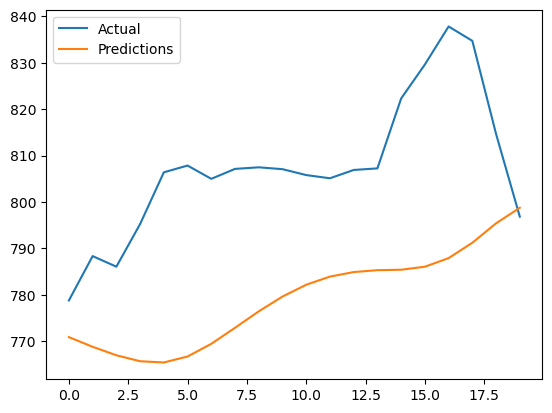

In [91]:
plt.plot(y_test, label='Actual')
plt.plot(y_hat, label='Predictions')
plt.legend()
plt.show()